# Center Loss in Keras

### Item recognition 'the sequel' - using Center Loss with Transfer Learning

Using InceptionV3

The implementation of **Center Loss** came from: [handongfeng/MNIST-center-loss](https://github.com/handongfeng/MNIST-center-loss/blob/master/centerLoss_MNIST.py)

**Articles:**
- [A Discriminative Feature Learning Approach for Deep Face Recognition](https://ydwen.github.io/papers/WenECCV16.pdf)
- [Understanding Center Loss Based Network for Image Retrieval with Few Training Data](https://openaccess.thecvf.com/content_ECCVW_2018/papers/11132/Ghosh_Understanding_Center_Loss_Based_Network_for_Image_Retrieval_with_Few_ECCVW_2018_paper.pdf)

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
%matplotlib notebook
%load_ext tensorboard

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array
#from tensorflow.keras.preprocessing import image_dataset_from_directory # cant import in Tensorflow v2.2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.regularizers import l2
from tensorflow.keras import losses
from tensorflow.keras import optimizers

import matplotlib.pyplot as plt
import numpy as np
import random
from numpy.random import default_rng

print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.2.0


In [3]:
#import os

In [4]:
from centerLoss import prelu, zero_loss, my_model
from centerLoss import CenterLossLayer

In [5]:
from utils import tbProjector, create_batch, create_testdata

In [6]:
#tf.test.is_gpu_available()
tf.config.list_physical_devices('GPU')

[]

In [7]:
tf.config.list_physical_devices('CPU')

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

## Counting Training Data 

In [8]:
#(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
#print(x_train.shape)

In [9]:
#from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Input, BatchNormalization, Activation
#from tensorflow.keras.layers import Dropout, Flatten, Dense
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.models import Model
#from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

In [10]:
image_dir = "image_data"
train_dir = os.path.join(image_dir, "train")
print(train_dir)

train_classnum = len(os.listdir(train_dir))
print("items = {}".format(len(os.listdir(train_dir))))

image_data/train
items = 706


In [11]:
all_images = 0
class_list = sorted(os.listdir(train_dir))
for i in class_list:
    #print(i)
    all_images += len(os.listdir(os.path.join(train_dir, i)))
print("All image files = {}".format(all_images))
print("class_list[:10] = {}".format(class_list[:10]))

All image files = 12070
class_list[:10] = ['aubeer2_0', 'aubeer2_1', 'aubeer2_10', 'aubeer2_11', 'aubeer2_12', 'aubeer2_14', 'aubeer2_15', 'aubeer2_16', 'aubeer2_17', 'aubeer2_18']


In [12]:
#_BATCH_SIZE = 1024
#_BATCH_SIZE = 256
_BATCH_SIZE = 64

## Setup train data generator

In [13]:
'''
train_ds = image_dataset_from_directory(
    directory='image_data/train',
    labels='inferred',
    label_mode='categorical',
    batch_size=_BATCH_SIZE,
    image_size=(224, 224))
'''

"\ntrain_ds = image_dataset_from_directory(\n    directory='image_data/train',\n    labels='inferred',\n    label_mode='categorical',\n    batch_size=_BATCH_SIZE,\n    image_size=(224, 224))\n"

In [14]:
train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    'image_data/train',
    target_size=(224, 224),
    batch_size=_BATCH_SIZE,
    class_mode='categorical'
    ) 

Found 12070 images belonging to 706 classes.


In [15]:
def plot_dataset(image_samples):

    #plt.figure(figsize=(5, 2))
    fig, axs = plt.subplots(len(image_samples)//5, 5)
                            
    count = 0
    for i in range(len(image_samples)//5):
        for j in range(5):
            #print("i = {}, j = {}".format(i, j))
            #plt.subplot(3, 3, 1 + i + j)
            axs[i, j].imshow(image_samples[count])
            plt.xticks([])
            plt.yticks([])
            count+=1
        #plt.title(examples[1][i])
    plt.show()

(64, 224, 224, 3)
(64, 706)


<IPython.core.display.Javascript object>


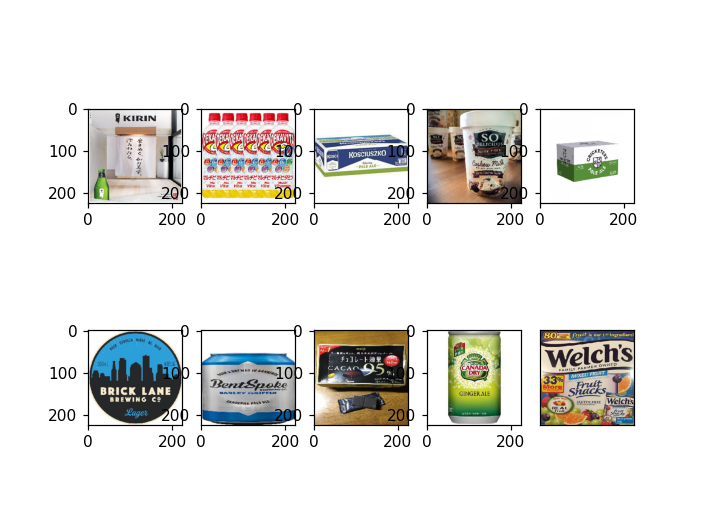

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [16]:
#X, Y = train_ds
(X, Y) = next(train_generator)
print(X.shape)
print(Y.shape)

plot_dataset(X[:10])
print(Y[:10])

## Setup validation data generator

In [17]:
valid_datagen = ImageDataGenerator(rescale=1./255)

valid_generator = valid_datagen.flow_from_directory(
    'image_data/valid',
    target_size=(224, 224),
    batch_size=_BATCH_SIZE,
    class_mode='categorical'
    ) 

Found 1589 images belonging to 90 classes.


## Load a pre-trained model and attach some fully-connected layers

In [18]:
emb_size = 128

img_input = keras.Input(shape=(224, 224, 3))
train_labels = keras.Input(shape=(train_classnum,))

final_output, side_output = my_model(img_input, train_labels, emb_size)
model = keras.Model(inputs=[img_input, train_labels], outputs=[final_output, side_output])
model.summary()

706
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 5, 5, 2048)   21802784    input_1[0][0]                    
__________________________________________________________________________________________________
global_average_pooling2d (Globa (None, 2048)         0           inception_v3[1][0]               
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           global_average_pooling2d[0][0]   
__________________________________________________________________________________________

## compile

In [19]:
lambda_centerloss = 0.01
initial_learning_rate = 1e-3

optim = optimizers.SGD(lr=initial_learning_rate, momentum=0.9)
model.compile(optimizer=optim,
                  loss=[losses.categorical_crossentropy, zero_loss],
                  loss_weights=[1, lambda_centerloss])

## Define data generation wrapper

In [20]:
def datagen_wrapper(gen, batch_size=64):
    dummy = np.zeros((batch_size, 1))
    #dummy2 = np.zeros((x_test.shape[0], 1))
    while True:
        (X, Y) = next(gen)    
        yield([X, Y], [Y, dummy])


## Prepare Tensorboard log

In [21]:
from datetime import date, time, datetime
import time

#datetimestr = datetime.now().__str__()
#timestamp = datetimestr.split()[0] + "_" + datetimestr.split()[1].split('.')[0]

epoch_time = int(time.time())

In [22]:
log_dir_rel = "logs/logs-{}".format(epoch_time)
#log_dir = os.path.abspath(log_dir_rel)
log_dir = os.path.abspath("logs/train_log")

if not os.path.exists(log_dir):
    os.makedirs(log_dir)
    
_TB_METADATA = 'metadata.tsv'

print(log_dir)

/home/chieko/Projects/ImageRecognition2/ItemRecogCenterLoss/logs/train_log


In [24]:
# Validation Data for Tensorboard
x_val_tb = create_testdata(datadir='train', tblog_dir=log_dir, metadatafile=_TB_METADATA)
y_val_tb = np.zeros((x_val_tb.shape[0], emb_size))

In [25]:
epochs=2
steps_per_epoch = int(all_images/_BATCH_SIZE)

reduced_model = keras.Model(inputs=model.input[0], outputs=model.get_layer('side_out').output)

model.fit(datagen_wrapper(train_generator, _BATCH_SIZE),
            steps_per_epoch=steps_per_epoch,
            #batch_size=_BATCH_SIZE,
            epochs=epochs,
            verbose=1,
            callbacks=[
                    tbProjector(
                        reduced_model,
                        x_val_tb, y_val_tb,
                        log_dir, _TB_METADATA
                    )])

Epoch 1/2
188/188 [==============================] - 272s 1s/step - loss: 7.2870 - main_out_loss: 6.5649 - centerlosslayer_loss: 68.0228
Epoch 2/2
188/188 [==============================] - 279s 1s/step - loss: 6.6485 - main_out_loss: 6.5592 - centerlosslayer_loss: 4.7575


## Create Siamese Network


input_anchor = tf.keras.layers.Input(shape=(224, 224, 3))
input_positive = tf.keras.layers.Input(shape=(224, 224, 3))
input_negative = tf.keras.layers.Input(shape=(224, 224, 3))

embedding_anchor = embedding_model(input_anchor)
embedding_positive = embedding_model(input_positive)
embedding_negative = embedding_model(input_negative)

all_output = tf.keras.layers.concatenate([embedding_anchor, embedding_positive, embedding_negative], axis=1)

net = tf.keras.models.Model([input_anchor, input_positive, input_negative], all_output)
net.summary()

## Define Triplet Loss

**NOTE:** The following explanation came from [Coursera "Siamese Network with Triplet Loss in Keras"](https://www.coursera.org/learn/siamese-network-triplet-loss-keras/home/welcome)

---

A loss function that tries to pull the Embeddings of Anchor and Positive Examples closer, and tries to push the Embeddings of Anchor and Negative Examples away from each other.

Root mean square difference between Anchor and Positive examples in a batch of N images is:
$
\begin{equation}
d_p = \sqrt{\frac{\sum_{i=0}^{N-1}(f(a_i) - f(p_i))^2}{N}}
\end{equation}
$

Root mean square difference between Anchor and Negative examples in a batch of N images is:
$
\begin{equation}
d_n = \sqrt{\frac{\sum_{i=0}^{N-1}(f(a_i) - f(n_i))^2}{N}}
\end{equation}
$

For each example, we want:
$
\begin{equation}
d_p \leq d_n
\end{equation}
$

Therefore,
$
\begin{equation}
d_p - d_n \leq 0
\end{equation}
$

This condition is quite easily satisfied during the training.

We will make it non-trivial by adding a margin (alpha):
$
\begin{equation}
d_p - d_n + \alpha \leq 0
\end{equation}
$

Given the condition above, the Triplet Loss L is defined as:
$
\begin{equation}
L = max(d_p - d_n + \alpha, 0)
\end{equation}
$

In [ ]:
#def triplet_loss(alpha, emb_dim):
#    def loss(y_true, y_pred):
#        anc, pos, neg = y_pred[:, :emb_dim], y_pred[:, emb_dim:2*emb_dim], y_pred[:, 2*emb_dim:]
#        dp = tf.reduce_mean(tf.square(anc - pos), axis=1)
#        dn = tf.reduce_mean(tf.square(anc - neg), axis=1)
#        return tf.maximum(dp - dn + alpha, 0.)
#    return loss

from utils import triplet_loss

## Define Data Generator

In [ ]:
def data_generator(batch_size=256):
    while True:
        x = create_batch(batch_size, 'train')
        y = np.zeros((batch_size, 3*emb_size))
        #print("x len = {}".format(len(x)))
        #print("x = {}".format(x))
        yield x, y

## Metrics

- `pos_mean` : Mean of anchor - positive distances (squared)
- `neg_mean` : Mean of anchor - negative distances (squared)

In [ ]:
def pos_mean(y_true, y_pred):
    anchor, positive, negative = y_pred[:,:emb_size], y_pred[:,emb_size:2*emb_size], y_pred[:,2*emb_size:]
    positive_dist = tf.reduce_mean(tf.square(anchor - positive), axis=1)
    
    return tf.reduce_mean(positive_dist)

def neg_mean(y_true, y_pred):
    anchor, positive, negative = y_pred[:,:emb_size], y_pred[:,emb_size:2*emb_size], y_pred[:,2*emb_size:]
    negative_dist = tf.reduce_mean(tf.square(anchor - negative), axis=1)
    
    return tf.reduce_mean(negative_dist)

## Save test embeddings for Tensorboard

In [ ]:
test_dir = os.path.join(image_dir, "test")
print(test_dir)
print("items = {}".format(len(os.listdir(test_dir))))

In [ ]:
all_images_test = 0
class_list_test = sorted(os.listdir(test_dir))
for i in class_list_test:
    #print(i)
    all_images_test += len(os.listdir(os.path.join(test_dir, i)))
print("All test image files = {}".format(all_images_test))
#print("class_list[:10] = {}".format(class_list[:10]))

In [ ]:
from datetime import date, time, datetime
import time

#datetimestr = datetime.now().__str__()
#timestamp = datetimestr.split()[0] + "_" + datetimestr.split()[1].split('.')[0]

epoch_time = int(time.time())

In [ ]:
import datetime
log_dir_rel = "logs/logs-{}".format(epoch_time)
log_dir = os.path.abspath(log_dir_rel)

if not os.path.exists(log_dir):
    os.makedirs(log_dir)
    
_TB_METADATA = 'metadata.tsv'

## Make test data (for Tensorboard)

In [ ]:
x_test = create_testdata(tblog_dir=log_dir, metadatafile=_TB_METADATA)
y_test = np.zeros((x_test.shape[0], emb_size))
print(x_test.shape)
print(y_test.shape)

# Task 9: Model Training

In [ ]:
batch_size = _BATCH_SIZE
epochs = 10
steps_per_epoch = int(all_images/batch_size)
print("step_per_epoch = {}".format(steps_per_epoch))
print("Tensorboard log_dir = {}".format(log_dir))

net.compile(loss=triplet_loss(0.2, emb_size), optimizer='adam', metrics=[
    pos_mean, neg_mean])

_ = net.fit(
    data_generator(batch_size),
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    callbacks=[
        tbProjector(
            embedding_model,
            x_test, y_test,
            log_dir, _TB_METADATA
        )]
)

In [ ]:
model_filename = "siameseN_inceptionV3_" + str(epoch_time) + ".h5"

net.save(model_filename)
print("Trained model was saved into {}.".format(model_filename))

In [ ]:
embmodel_filename = "embeddings_inceptionV3_" + str(epoch_time) + ".h5"
embedding_model.save(embmodel_filename)
print("Trained model was saved into {}.".format(model_filename))